In [1]:
# import modules
import numpy as np
import astropy.units as u
import astropy.table as tbl
from ReadFile import Read
from CenterofMass import CenterOfMass
from astropy.constants import G
G = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Worked with Adrien Masini


Separation between the MW and M31 = 769.0 kpc
Relative Velocity between the MW and M31 = 118.0 km / s
Relative Position between M33 and M31 =  201.0 kpc
Relative Velocity between M33 and M31 =  199.0 km / s


In [2]:
G

<Quantity 4.30091727e-06 km2 kpc / (s2 solMass)>

In [14]:
class MassProfile:
# Class to define mass profile of a given galaxy at SnapNumber 0 to determine each 
# falaxy's rotation curve
    
    
    def __init__(self, galaxy, Snap):
    # Initialize the instance of this Class with the following properties:
    # galaxy and Snapshot
    
        # inputs to recontruct the filenumber to the value "000"
        ilbl = '000' + str(Snap)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        self.filename = "%s_"%(galaxy) + ilbl + '.txt'
        
        
        # read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename)         
      
        
        #read data for x,y,z positions and mass with correct units
        
        self.m = self.data['m']
       
        #Positions
        self.x = self.data['x'] * u.kpc
        self.y = self.data['y'] * u.kpc
        self.z = self.data['z'] * u.kpc
        
        # Store the name of the galaxy as a global property
        self.gname = galaxy
        
        
        # Function that computer the mass enclosed within a given radius of the COM position
        # for a specified galaxy an a specified component of that galaxy
        
    def MassEnclosed(self, ptype, r):
        # Inputs: particle type and radii array in kpc
        # Returns:  mass array in units of Msun
        
        # Reading particle type
        index = np.where(self.data['type'] == ptype)
        
        # Type of particle can be 1,2 or 3.
        # 1=DM, 2=Disk, 3=Bulge
        
        # making an object COM from CenterofMass
        COM = CenterOfMass(self.filename, ptype)
        
        # calling COM_P
        COM_P = COM.COM_P(0.1)
        
        # getting the position form any point to the center of mass
        POSX = self.x[index] - COM_P[0]
        POSY = self.y[index] - COM_P[1]
        POSZ = self.z[index] - COM_P[2]
        
        # getting the vector
        POS = np.sqrt(POSX**2 + POSY**2 + POSZ**2)
       
        # Computing the radius
        #r = np.arange(0.25, 30.5, 1.5)
        mass = self.m[index]
        
        # defining an empty array to store the mass
        menc = np.zeros(np.size(r))
        
        # looping through the mass 
        for i in range( np.size(r)):
            
            # creating the index that selects the position of the partciles withing the desired radius
            index2 = np.where(POS < r[i]*u.kpc)
            
            # this is the total mass enclosed in the given radius
            menc[i] = np.sum(mass[index2])        
          
        return menc * u.Msun * 1e10     
    
        
    def MassEnclosedTotal(self, r):
        # This function calls MassEnclosed to compute the mass enclosed within the radius aray
        # for each particle type
        # Returns the total enclosed mass (bulge, halo and disk) at the given radius as an aray in units of Msun
        
         if self.gname == 'M33' : 
            mtot = self.MassEnclosed(1,r) + self.MassEnclosed(2,r)
            return mtot
         else :
            mtot = self.MassEnclosed(1,r) + self.MassEnclosed(2,r) + self.MassEnclosed(3,r)
            return mtot
    
    def HernquistMass(self, a, Mhalo):
    
        # This function computes the mass enclosed within a given radius using theoretical profile:
        # rho(r) =(M*a/2*pi*r)(1/(r+a)**3)
        # M(r) = Mhalo*r**2 /(a+r)**2
        # Inputs:
        #       radius, scale factor a, halo mass.
        # Returns:
        #       Halo mass in units of Msun 
        
        Mr = Mhalo*r**2 / (a+r)**2*u.Msun
        
        return Mr 
    
    def circ_vel(self, ptype, r):
        # Function that computes the circular velocity using Mass enclosed at each radius
        # Assume spherical symmetry
        # Inputs:
        #       ptype and array of radius
        # Output:
        #       array of circular speeds in units of km/s 
        
        Men = self.MassEnclosed(ptype, r)
        
        vc = np.sqrt(G*Men/r/u.kpc)
                
        return np.round(vc,2)
    
    def circ_vel_tot(self, r):
        # Inputs: array of radii
        # Returns: array of total circular velocity (km/s) composed by all galaxy components
        
        Mentot = self.MassEnclosedTotal(r)
        
        vct = np.round(np.sqrt(G*Mentot/r/u.kpc),2)
                
        return vct
        
    def HernquistVCirc(self, r, a, Mhalo):
        # Function computes the circular speed using Hernquist mass profile
        # Input:
        #      radius (kpc), scale factor a, Halo mass (HernquistMass) Msun
        
        hm = self.HernquistMass(a, Mhalo)
        
        hvct = np.round(np.sqrt(G*hm/r/u.kpc),2)
        
        return hvct

In [15]:
MW = MassProfile("MW", 0)
M31 = MassProfile("M31", 0)
M33 = MassProfile("M33", 0)


In [16]:
r = np.arange(0.25, 30.5, 1.5)

In [17]:
# Components of MW
MW_M_ENC_DM = MW.MassEnclosed(1, r)
MW_M_ENC_D = MW.MassEnclosed(2, r)
MW_M_ENC_B = MW.MassEnclosed(3, r)

# Components of M31
M31_M_ENC_DM = M31.MassEnclosed(1, r)
M31_M_ENC_D = M31.MassEnclosed(2, r)
M31_M_ENC_B = M31.MassEnclosed(3, r)

#Components of M33
M33_M_ENC_DM = M33.MassEnclosed(1, r)
M33_M_ENC_D = M33.MassEnclosed(2, r)
M33_M_ENC_B =  np.zeros(np.size(r))

In [18]:
#MW_HM = MW.HernquistMass(a, MW_M_ENC_DM)
#print(MW_HM)
#M31_HM = M31.HernquistMass(a, M31_M_ENC_DM)
#print(M31_HM)
#M33_HM = M33.HernquistMass(a, M33_M_ENC_DM)
#print(M33_HM)

In [19]:
#print(MW_M_ENC_DM)
#print(M31_M_ENC_DM)
#print(M33_M_ENC_B)

In [20]:
MW_MT_ENC = MW.MassEnclosedTotal(r)
#print(MW_MT_ENC)
M31_MT_ENC = M31.MassEnclosedTotal(r)
#print(MW_MT_ENC)
M33_MT_ENC = M33.MassEnclosedTotal(r)
#print(M33_MT_ENC)

In [21]:
# Circ Vel MW by components
MW_CIRC_VEL_DM = MW.circ_vel(1, r)
#print(MW_CIRC_VEL_DM)
MW_CIRC_VEL_D = MW.circ_vel(2, r)
#print(MW_CIRC_VEL_D)
MW_CIRC_VEL_B = MW.circ_vel(3, r)
#print(MW_CIRC_VEL_B)

# Circ Vel M31 by components
M31_CIRC_VEL_DM = M31.circ_vel(1, r)
#print(M31_CIRC_VEL_DM)
M31_CIRC_VEL_D = M31.circ_vel(2, r)
#print(M31_CIRC_VEL_D)
M31_CIRC_VEL_B = M31.circ_vel(3, r)
#print(M31_CIRC_VEL_B)

# Circ Vel MW by components
M33_CIRC_VEL_DM = M33.circ_vel(1, r)
#print(M33_CIRC_VEL_DM)
M33_CIRC_VEL_D = M33.circ_vel(2, r)
#print(M33_CIRC_VEL_D)
M33_CIRC_VEL_B = np.zeros(np.size(r))
#print(M33_CIRC_VEL_B)

In [22]:
MW_CIRC_VEL_TOT = MW.circ_vel_tot(r)
#print(MW_CIRC_VEL_TOT)
M31_CIRC_VEL_TOT = M31.circ_vel_tot(r)
#print(M31_CIRC_VEL_TOT)
M33_CIRC_VEL_TOT = M33.circ_vel_tot(r)
#print(M33_CIRC_VEL_TOT)

In [23]:
#MW_HM = MW.HernquistVCirc(r,a, MW_M_ENC_DM)
#print(MW_HM)
#M31_HM = M31.HernquistVCirc(r,a, M31_M_ENC_DM)
#print(M31_HM)
#M33_HM = M33.HernquistVCirc(r,a, M33_M_ENC_DM)
#print(M33_HM)

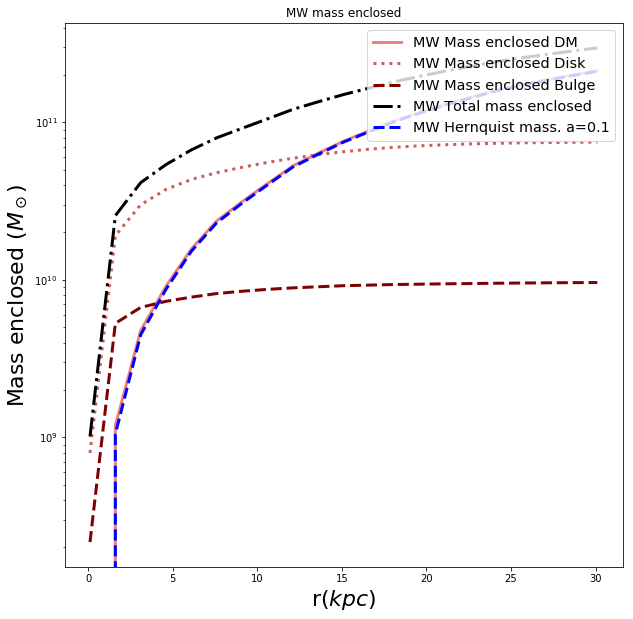

In [24]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot the default values (y axis log)
# ADD HERE

r =np.arange(0.1, 30.5, 1.5)

#MW mass enclosed
plt.title('MW mass enclosed')
ax.semilogy(r,MW_M_ENC_DM,color='lightcoral', linewidth=3, label='MW Mass enclosed DM')
ax.semilogy(r,MW_M_ENC_D,color='indianred', linewidth=3, linestyle=':', label='MW Mass enclosed Disk')
ax.semilogy(r,MW_M_ENC_B,color='maroon', linewidth=3, linestyle='--',  label='MW Mass enclosed Bulge')
ax.semilogy(r,MW_MT_ENC,color='black', linewidth=3, linestyle='-.',  label='MW Total mass enclosed')
ax.semilogy(r,MW.HernquistMass(.1, MW_M_ENC_DM),color='blue', linewidth=3, linestyle='--',  label='MW Hernquist mass. a=0.1')


# Add labels
plt.xlabel(r'r($kpc$)', fontsize=22)
plt.ylabel(r'Mass enclosed ($M_\odot$)', fontsize=22)

#set axis limits
#plt.xlim(-17,-26)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')




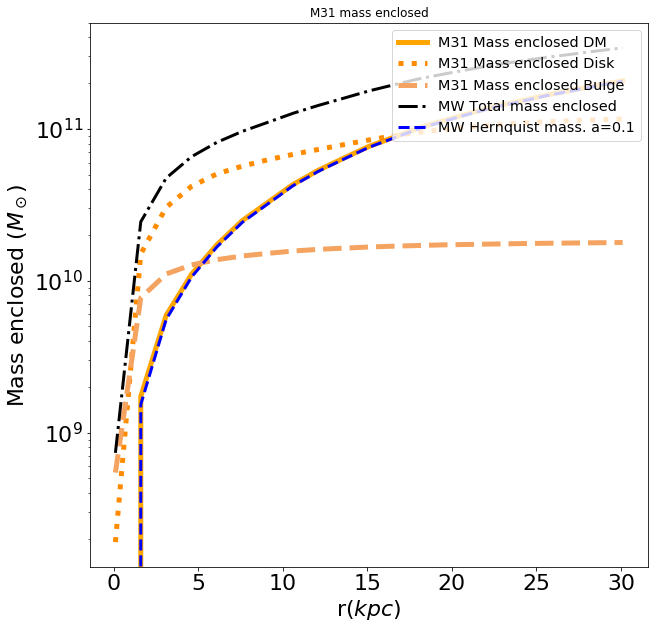

In [25]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)


r =np.arange(0.1, 30.5, 1.5)

#M31 mass enclosed
plt.title('M31 mass enclosed')
ax.semilogy(r,M31_M_ENC_DM,color='orange', linewidth=5, label='M31 Mass enclosed DM')
ax.semilogy(r,M31_M_ENC_D,color='darkorange', linewidth=5, linestyle=':', label='M31 Mass enclosed Disk')
ax.semilogy(r,M31_M_ENC_B,color='sandybrown', linewidth=5, linestyle='--',  label='M31 Mass enclosed Bulge')
ax.semilogy(r,M31_MT_ENC,color='black', linewidth=3, linestyle='-.',  label='MW Total mass enclosed')
ax.semilogy(r,M31.HernquistMass(.1, M31_M_ENC_DM),color='blue', linewidth=3, linestyle='--',  label='MW Hernquist mass. a=0.1')


# Add labels
plt.xlabel(r'r($kpc$)', fontsize=22)
plt.ylabel(r'Mass enclosed ($M_\odot$)', fontsize=22)

#set axis limits
#plt.xlim(-17,-26)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')



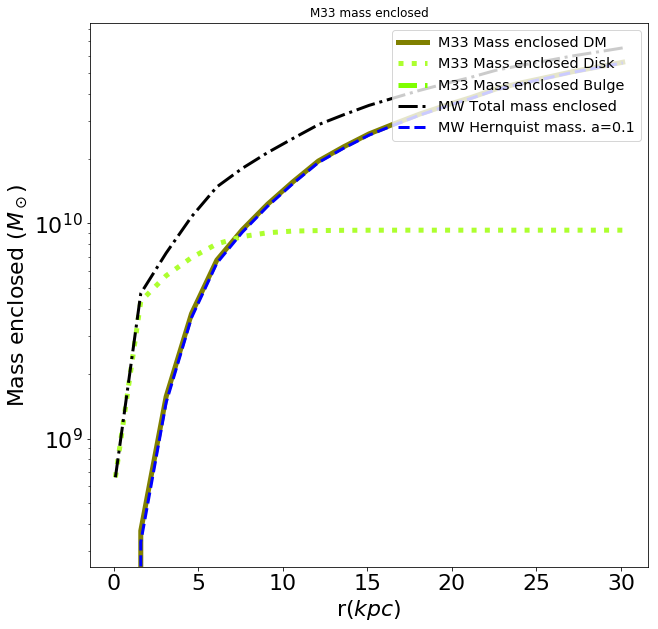

In [26]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)


r =np.arange(0.1, 30.5, 1.5)

#M33 mass enclosed
plt.title('M33 mass enclosed')
ax.semilogy(r,M33_M_ENC_DM,color='olive', linewidth=5, label='M33 Mass enclosed DM')
ax.semilogy(r,M33_M_ENC_D,color='greenyellow', linewidth=5, linestyle=':', label='M33 Mass enclosed Disk')
ax.semilogy(r,M33_M_ENC_B,color='chartreuse', linewidth=5, linestyle='--',  label='M33 Mass enclosed Bulge')
ax.semilogy(r,M33_MT_ENC,color='black', linewidth=3, linestyle='-.',  label='MW Total mass enclosed')
ax.semilogy(r,M33.HernquistMass(.1, M33_M_ENC_DM),color='blue', linewidth=3, linestyle='--',  label='MW Hernquist mass. a=0.1')


# Add labels
plt.xlabel(r'r($kpc$)', fontsize=22)
plt.ylabel(r'Mass enclosed ($M_\odot$)', fontsize=22)

#set axis limits
#plt.xlim(-17,-26)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')



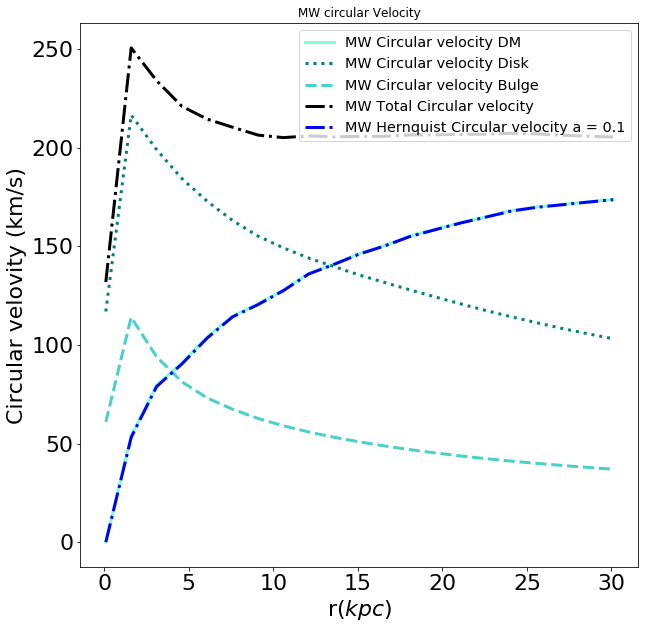

In [27]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot the default values (y axis log)
# ADD HERE

r =np.arange(0.1, 30.5, 1.5)

#MW Circular Velocity
plt.title('MW circular Velocity')
plt.plot(r,MW_CIRC_VEL_DM,color='aquamarine', linewidth=3, label='MW Circular velocity DM')
plt.plot(r,MW_CIRC_VEL_D,color='teal', linewidth=3, linestyle=':', label='MW Circular velocity Disk')
plt.plot(r,MW_CIRC_VEL_B,color='mediumturquoise', linewidth=3, linestyle='--',  label='MW Circular velocity Bulge')
plt.plot(r,MW_CIRC_VEL_TOT,color='black', linewidth=3, linestyle='-.',  label='MW Total Circular velocity')
plt.plot(r,MW.HernquistVCirc(r,0.1, MW_M_ENC_DM),color='blue', linewidth=3, linestyle='-.',  label='MW Hernquist Circular velocity a = 0.1')

# Add labels
plt.xlabel(r'r($kpc$)', fontsize=22)
plt.ylabel(r'Circular velovity (km/s)', fontsize=22)

#set axis limits
#plt.xlim(-17,-26)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')



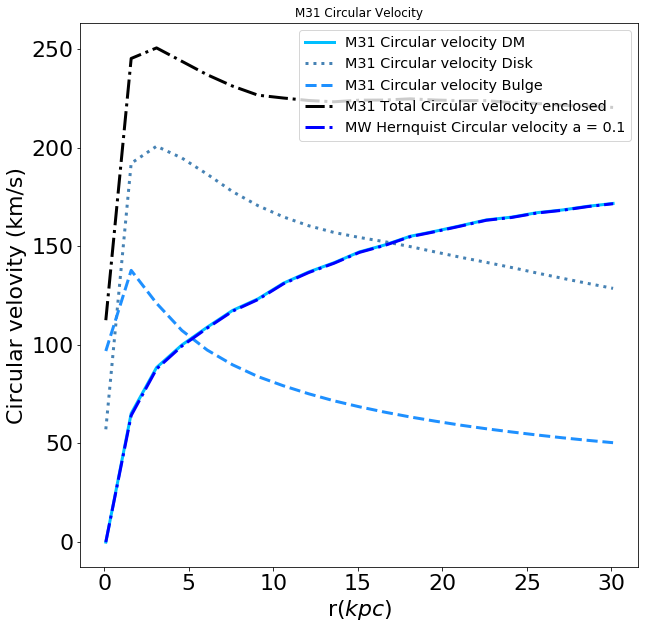

In [28]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot the default values (y axis log)
# ADD HERE

r =np.arange(0.1, 30.5, 1.5)

#M31 Ciruclar Velocity
plt.title('M31 Circular Velocity')
plt.plot(r,M31_CIRC_VEL_DM,color='deepskyblue', linewidth=3, label='M31 Circular velocity DM')
plt.plot(r,M31_CIRC_VEL_D,color='steelblue', linewidth=3, linestyle=':', label='M31 Circular velocity Disk')
plt.plot(r,M31_CIRC_VEL_B,color='dodgerblue', linewidth=3, linestyle='--',  label='M31 Circular velocity Bulge')
plt.plot(r,M31_CIRC_VEL_TOT,color='black', linewidth=3, linestyle='-.',  label='M31 Total Circular velocity enclosed')
plt.plot(r,M31.HernquistVCirc(r,0.1, M31_M_ENC_DM),color='blue', linewidth=3, linestyle='-.',  label='MW Hernquist Circular velocity a = 0.1')

# Add labels
plt.xlabel(r'r($kpc$)', fontsize=22)
plt.ylabel(r'Circular velovity (km/s)', fontsize=22)

#set axis limits
#plt.xlim(-17,-26)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')



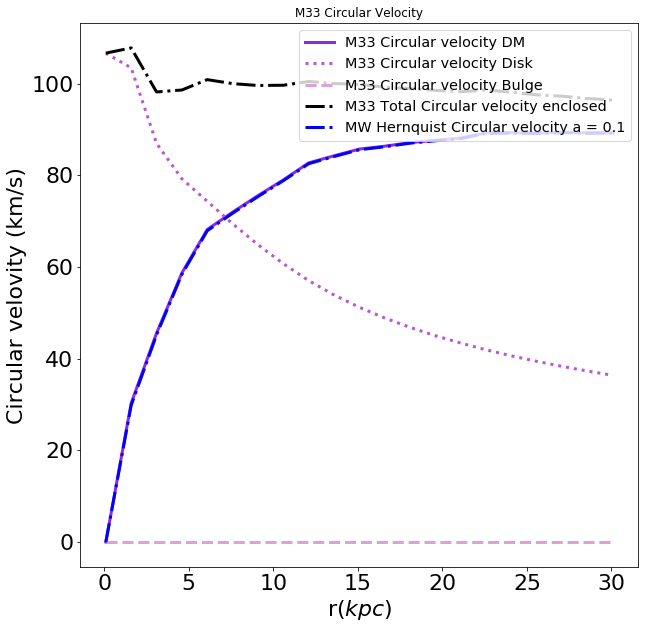

In [29]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot the default values (y axis log)
# ADD HERE

r =np.arange(0.1, 30.5, 1.5)

#M33 Circular Velocity
plt.title('M33 Circular Velocity')
plt.plot(r,M33_CIRC_VEL_DM,color='blueviolet', linewidth=3, label='M33 Circular velocity DM')
plt.plot(r,M33_CIRC_VEL_D,color='mediumorchid', linewidth=3, linestyle=':', label='M33 Circular velocity Disk')
plt.plot(r,M33_CIRC_VEL_B,color='plum', linewidth=3, linestyle='--',  label='M33 Circular velocity Bulge')
plt.plot(r,M33_CIRC_VEL_TOT,color='black', linewidth=3, linestyle='-.',  label='M33 Total Circular velocity enclosed')
plt.plot(r,M33.HernquistVCirc(r,0.1, M33_M_ENC_DM),color='blue', linewidth=3, linestyle='-.',  label='MW Hernquist Circular velocity a = 0.1')
# Add labels
plt.xlabel(r'r($kpc$)', fontsize=22)
plt.ylabel(r'Circular velovity (km/s)', fontsize=22)

#set axis limits
#plt.xlim(-17,-26)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')

